In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from scipy import integrate
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('matplotlibrc')

## Gegenschein and Vorderschein with 3D galactic synchrotron model

Following [Radio observational constraints on Galactic 3D-emission models](https://arxiv.org/pdf/0711.1572.pdf)

In [2]:
## units
# length: kpc
# B field: muGauss

### Coordinates
Cylindrical $(R, \phi, z)$ where $\phi=0$ corresponds to $l=0$ \
$R_\text{sun}$ is assumed to be 8.5 kpc.

### 6.1. Thermal electron density
#### 6.1.1. The model for diffuse ionized gas – NE2001
<img src="plots/NE2001.png" alt="drawing" width="400"/>

#### 6.1.2. The filling factor of the DIG – from free-free emission at 22.8 GHz
Filling factor of diffuse ionized gas (DIG)
$$f_e\equiv\frac{\langle n_e\rangle^2}{\langle n_e^2\rangle}$$
Berkhuijsen et al. (2006) derives
$$f_e(z)=\begin{cases}0.07\exp(|z|/0.5\text{kpc})\quad\\
  0.32\quad\text{for }z>0.75\text{kpc}\end{cases} $$

#### 6.1.3. The filling factor of the DIG – from low-frequency absorption
#### 6.1.4. Remarks
In summary the NE2001 model combined with the filling factor obtained by Berkhuijsen et al. (2006) are proven to be sufficient to model the low latitude DIG. 

### 6.2. Regular magnetic field properties
Total magnetic field = regular component + random component
$$B_\text{tot}=B+b.$$
Regular component has a disk and a halo component
$$B=B^D+B^H.$$
The former is constrained by RMs near the Galactic plane ($|b|<5^\circ$) and the latter by an all-sky RM map from EGS data.

#### 6.2.1. The disk field
Axi-symmetric spiral (ASS) or  Bi-symmetric spiral (BSS)

We collected a number of published models and
checked them for their ability to simulate the observed RMs in
the Galactic plane. The results are shown in Fig. 9. Obviously
none of the models is able to reproduce the observed systematic
features. This motivates us to revise the parameters previously
used.

\begin{equation}
\begin{cases}
B^D_R = D_1(R,\phi,z)D_2(R,\phi,z)\sin p \\
B^D_\phi = -D_1(R,\phi,z)D_2(R,\phi,z)\cos p \\
B^D_z = 0
\end{cases}
\end{equation}
where $D_1(R, \phi, z)$ constrains the spatial variation of the field
strength and $D_2(R, \phi, z)$ introduces reversals or asymmetries. $p$ is the pitch angle defined in the following graph (found [here](https://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1994A%26A...288..759H&defaultprint=YES&filetype=.pdf)):\
<img src="plots/pitch_angle.png" alt="drawing" width="400"/>

We use
$$D_1(R,z)=\begin{cases}
B_0\exp\left(-\frac{R-R_\bigodot}{R_0}-\frac{|z|}{z_0}\right)\quad &\text{for }R>R_c \\
B_c &\text{for }R<R_c\\
\end{cases}$$

The regular $z$-component of the Galactic magnetic field is
very small. Its strength is about 0.2 µG to 0.3 µG as estimated
by Han & Qiao (1994). We assume $B^D_z$ to be zero in our models.

We list three different magnetic field models
1. the ASS model plus reversals in rings (ASS+RING) -> AR
1. the ASS model plus reversals following arms (ASS+ARM) -> AA
1. the BSS model -> BS

In [7]:
def BD_AR(stz):
    R, _, z = stz
    R0, z0, Rc, Rsun = 10, 1, 5, 8.5 # kpc
    B0, Bc = 2, 2 # muG
    
    D1 = Bc if R < Rc else B0 * np.exp( -(R-Rsun)/R0 -np.abs(z)/z0 )
    D2 = float((7.5 < R) or (5 < R and R < 6))*2 - 1
    return np.array([0, -D1*D2, 0])

def BD_BS(stz):
    R, phi, z = stz
    R0, z0, Rc, Rsun = 6, 1, 3, 8.5 # kpc
    B0, Bc = 2, 2 # muG
    
    D1 = Bc if R < Rc else B0 * np.exp( -(R-Rsun)/R0 -np.abs(z)/z0 )
    if R > 6:
        Rb = 9
        p = -10/180 * np.pi
    else:
        Rb = 6
        p = -15/180 * np.pi
    beta = 1/np.tan(p)
    D2 = -np.cos(phi + beta*np.log(R/Rb))
    return np.array([D1*D2*np.sin(p), -D1*D2*np.cos(p), 0])

In [66]:
def visualize_hv(func, h_smax, h_zval, v_zmax, v_tval, npix, title=''):
    xs = np.linspace(-h_smax, h_smax, npix)
    ys = np.linspace(-h_smax, h_smax, npix)
    hslice = np.zeros((npix, npix))
    for ix, x in enumerate(tqdm(xs)):
        for iy, y in enumerate(ys):
            stz = (np.sqrt(x**2+y**2),  np.arctan2(y, x), h_zval)
            hslice[ix][iy] = func(stz)
    xs = np.linspace(0, plot_s, npix)
    zs = np.linspace(-plot_z, plot_z, npix)
    vslice = np.zeros((npix, npix))
    for ix, x in enumerate(tqdm(xs)):
        for iz, z in enumerate(zs):
            stz = (x, v_tval, z)
            vslice[iz][ix] = func(stz)
    fig, axs = plt.subplots(1, 2, figsize=(12,6))

    vmax = np.max(np.concatenate([hslice[hslice<np.inf], vslice[vslice<np.inf]]))
    im = axs[0].imshow(hslice, extent=(-plot_s, plot_s, -plot_s, plot_s), vmin=0, vmax=vmax, cmap='magma')
    axs[1].imshow(vslice, extent=(0, plot_s, -plot_z, plot_z), vmin=0, vmax=vmax, cmap='magma')
    axs[0].set(xlabel='x [kpc]', ylabel='y [kpc]', title=title+f'$z={h_zval}$~kpc')
    axs[1].set(xlabel='x [kpc]', ylabel='z [kpc]', title=title+f'$\phi={v_tval}^\circ$')
    fig.colorbar(im, ax=axs, orientation='horizontal', aspect=40)
    plt.show()

  0%|                                                                                       | 0/100 [00:00<?, ?it/s]/var/folders/24/spnpknrj5vb_jzkn8lgg5gth0000gn/T/ipykernel_81692/633515891.py:23: RuntimeWarning: divide by zero encountered in log
  D2 = -np.cos(phi + beta*np.log(R/Rb))
/var/folders/24/spnpknrj5vb_jzkn8lgg5gth0000gn/T/ipykernel_81692/633515891.py:23: RuntimeWarning: invalid value encountered in cos
  D2 = -np.cos(phi + beta*np.log(R/Rb))
100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 713.70it/s]


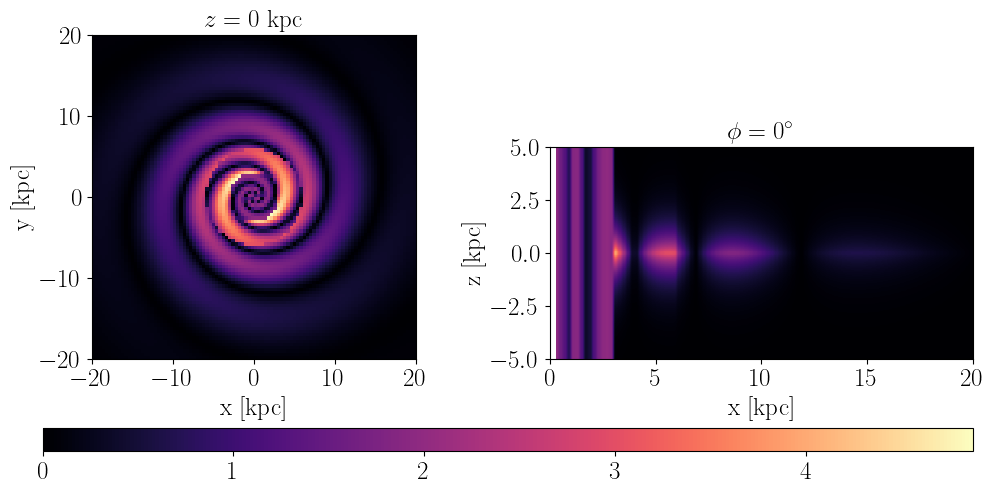

In [69]:
visualize_hv(lambda x: np.linalg.norm(BD_BS(x)), 20, 0, 5, 0, 100)

100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1213.61it/s]


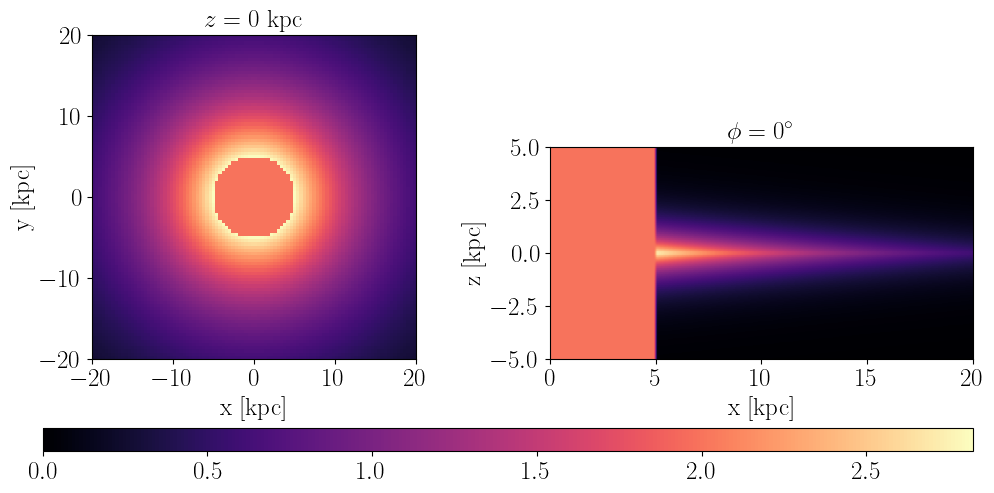

In [70]:
visualize_hv(lambda x: np.linalg.norm(BD_AR(x)), 20, 0, 5, 0, 100)

#### 6.2.2 Halo regular field
<img src="plots/Halo_B_field.png" alt="drawing" width="400"/>

In [36]:
def BH(stz):
    R, _, z = stz
    BH0, RH0, zH0 = 10, 4, 1.5
    zH1 = 0.2 if np.abs(z) < zH0 else 0.4
    return np.array([0, BH0 / (1+((np.abs(z)-zH0)/zH1)**2)*R/RH0*np.exp(-(R-RH0)/RH0), 0])

In [72]:
visualize_hv?

Signature: visualize_hv(func, h_smax, h_zval, v_zmax, v_tval, npix, title='')
Docstring: <no docstring>
File:      /var/folders/24/spnpknrj5vb_jzkn8lgg5gth0000gn/T/ipykernel_81692/588225375.py
Type:      function


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 933.04it/s]


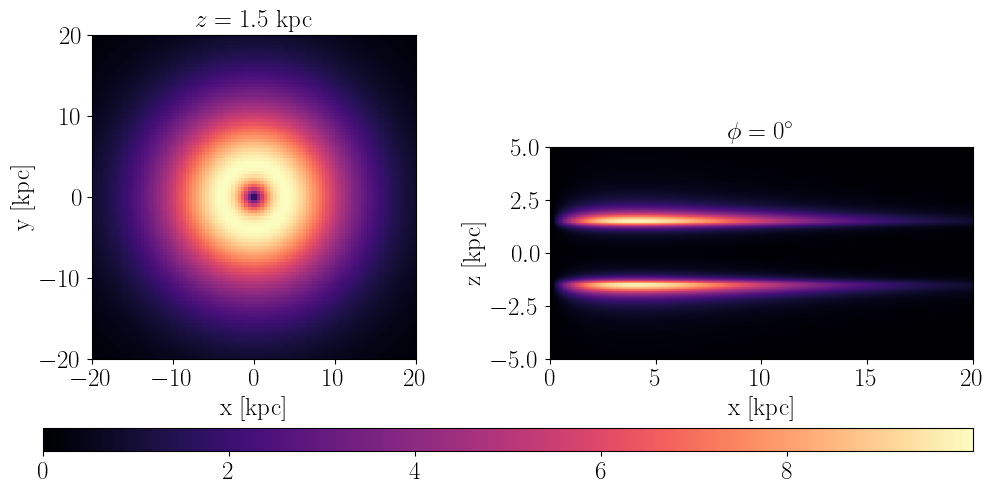

In [73]:
visualize_hv(lambda x: np.linalg.norm(BH(x)), 20, 1.5, 5, 0, 100)

#### 6.3.2. CR electron density
<img src="plots/CRelec_text.png" alt="drawing" width="400"/>

In [45]:
spec_ind_p = 3
spec_ind_alpha = (spec_ind_p+1)/2

def n(stz):
    s, t, z = stz
    if np.abs(z) > 1:
        return 0
    Rsun = 8.5
    return np.exp(-(np.maximum(s, 3) - Rsun)/8 -np.abs(z))

100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5460.05it/s]


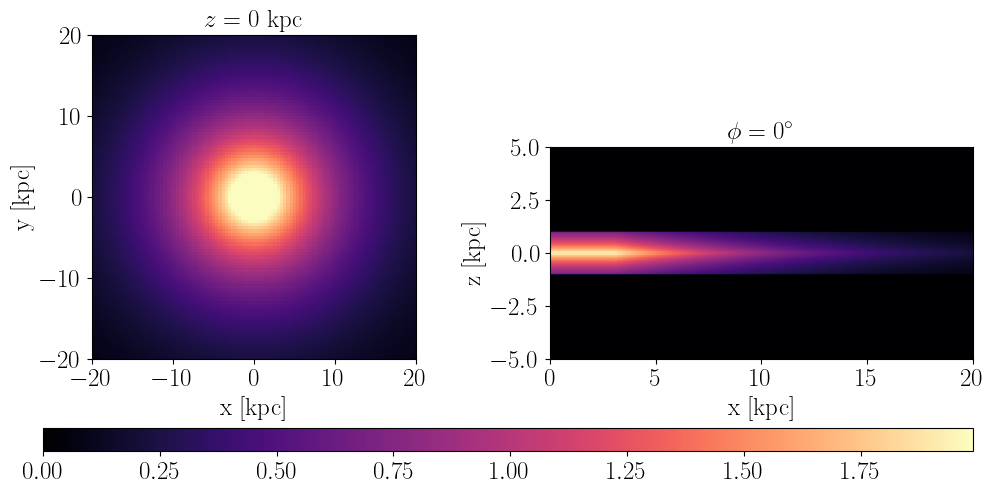

In [74]:
visualize_hv(n, 20, 0, 5, 0, 100)

## observed intensity at Sun location

In [52]:
# coordinate transformation
# GC: Galactic center
# G: Galactic
# GC:stz - GC:xyz - G:lbd
Rsun = 8.5 # kpc

def GCstz(lbd):
    l, b, d = lbd
    x = d * np.cos(b) * np.cos(l) - Rsun
    y = d * np.cos(b) * np.sin(l)
    z = d * np.sin(b)
    return ( np.sqrt(x**2+y**2), np.arctan2(y, x), z )

def Glbd(stz):
    s, t, z = stz
    x = s * np.cos(t)
    y = s * np.sin(t)
    z = z
    return ( np.arctan2(y, x+Rsun),
             np.arctan2(z, np.sqrt((x+Rsun)**2+y**2)),
             np.sqrt((x+Rsun)**2+y**2+z**2) )

power density $p(\vec x)=n(\vec x)B(\vec x)^\alpha$

In [53]:
# using total magnetic field (not caring about the angle)
def power_density(stz):
    B = np.linalg.norm(BH(stz) + BD_AR(stz))
    return n(stz) * B**spec_ind_alpha

In [54]:
def I_s(lb):
    l, b = lb
    def integrand(d):
        return power_density(GCstz([l, b, d]))
    val, err = integrate.quad(integrand, 0, np.inf)
    return val

In [55]:
I_s([0, 0.2])

/var/folders/24/spnpknrj5vb_jzkn8lgg5gth0000gn/T/ipykernel_81692/4195234356.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = integrate.quad(integrand, 0, np.inf)


17.772354776577014

In [56]:
# plot I_s
npix = 100
ls = np.linspace(np.pi, 3*np.pi, npix)
bs = np.linspace(-np.pi/6, np.pi/6, npix)
plot_v = np.zeros((npix,npix))
for il, l in enumerate(tqdm(ls)):
    for ib, b in enumerate(bs):
        plot_v[ib][il] = I_s([l, b])

 33%|█████████████████████████▋                                                    | 33/100 [00:39<01:27,  1.30s/it]/var/folders/24/spnpknrj5vb_jzkn8lgg5gth0000gn/T/ipykernel_81692/4195234356.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = integrate.quad(integrand, 0, np.inf)
100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [03:07<00:00,  1.87s/it]


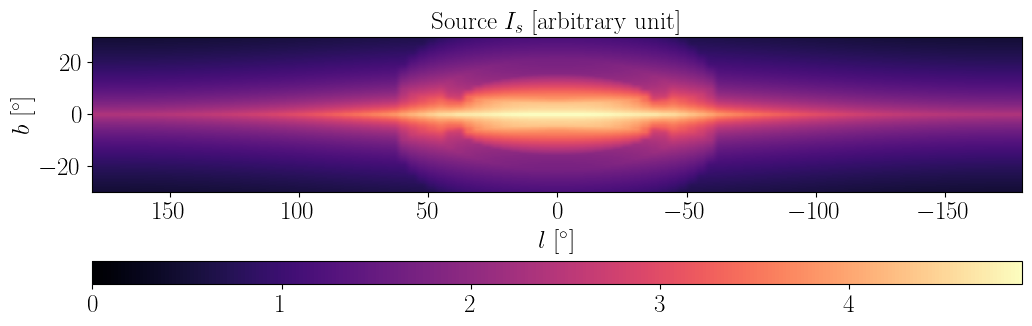

In [57]:
fig, ax = plt.subplots(figsize=(12,6))

plot_logv = np.log(plot_v)

im = ax.imshow(np.flip(plot_logv), extent=(180, -180, -30, 30), vmin=0, vmax=np.max(plot_logv), cmap='magma')
ax.set(xlabel='$l$ [$^\circ$]', ylabel='$b$ [$^\circ$]', title=r'Source $I_s$ [arbitrary unit]')
fig.colorbar(im, ax=ax, orientation='horizontal', aspect=40);